# Оглавление

* [Распределение рубрик в данных](#Распределение-рубрик-в-данных)
* [Обучение модели](#Обучение-модели)
* [Оценка качества поиска](#Оценка-качества-поиска)
    * [по УДК](#по-УДК)
    * [по ГРНТИ](#по-ГРНТИ)

In [12]:
import json
import artm
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import sys
sys.path.append('../../ap/utils')
from model_train import fit_topic_model
from search_quality import calculate_search_quality
from pathlib import Path
import config
from sklearn.linear_model import LogisticRegression
import joblib
import rank_metric
import config
import warnings

sys.path.append('../../research/experimental_code')
from Classification import GetAccuracy

sns.set(style='darkgrid', font_scale=1.7)

# Распределение рубрик в данных

In [13]:
udk_data = pd.DataFrame(pd.read_json("/data/datasets/Antiplagiat/udk_codes.json", typ='series')).reset_index()
udk_data.rename(columns={"index": "document id", 0: "topic type"}, inplace=True)
udk_data.head()

,document id,topic type
0,15139881,3
1,9505141,1
2,14613610,6
3,9592795,0
4,10082081,3


In [14]:
groupped_df = udk_data.groupby(by='topic type').count().sort_values(by='document id', ascending=False)
groupped_df.head()

,document id
topic type,
6,6009
3,4586
1,2479
5,2068
9,1452


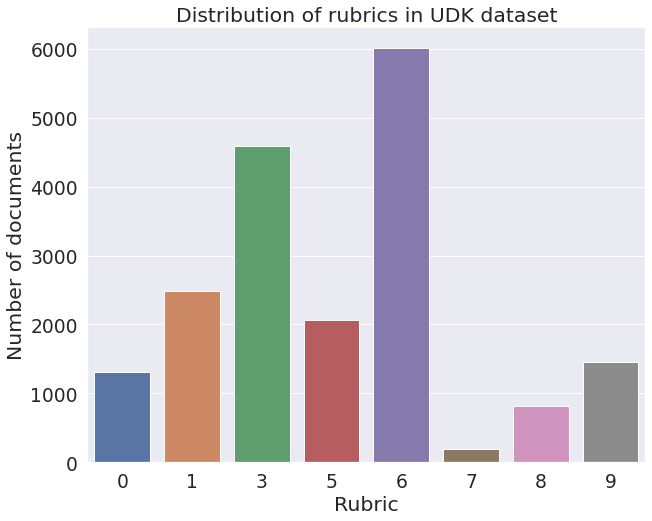

In [15]:
plt.figure(figsize=(10, 8))
sns.barplot(x=groupped_df.index, y=groupped_df['document id'])
plt.xlabel("Rubric")
plt.ylabel("Number of documents")
plt.title("Distribution of rubrics in UDK dataset")
plt.show()

In [16]:
grnti_data = pd.DataFrame(pd.read_json("/data/datasets/Antiplagiat/grnti_codes.json", typ='series')).reset_index()
grnti_data.rename(columns={"index": "document id", 0: "topic type"}, inplace=True)
grnti_data.head()

,document id,topic type
0,15130758,экономика. экономические науки
1,11909607,народное образование. педагогика
2,13918728,медицина и здравоохранение
3,11806946,государство и право. юридические науки
4,15585638,пищевая промышленность


In [17]:
df = grnti_data.groupby(by='topic type').count().sort_values(by='document id', ascending=False)

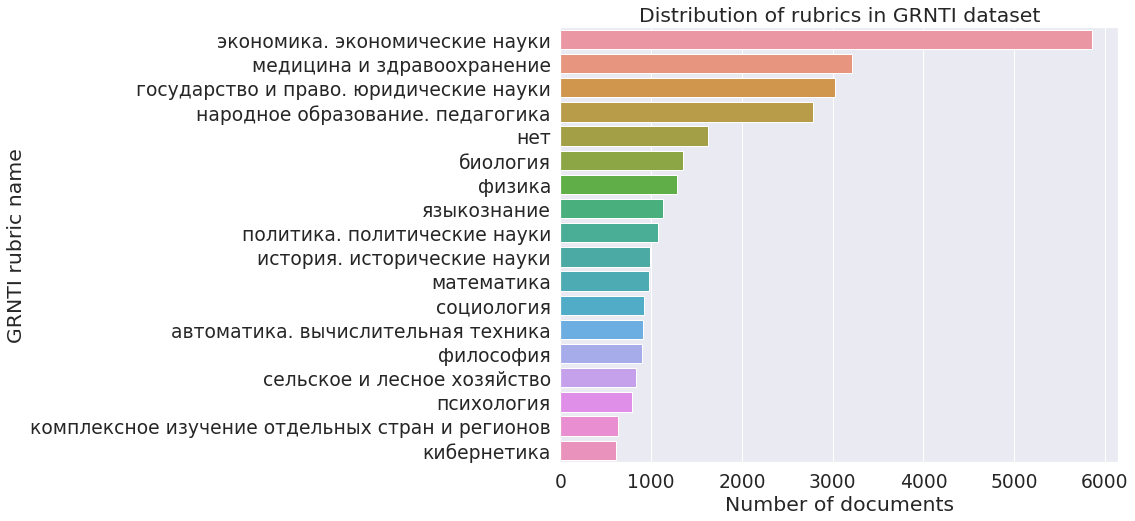

In [18]:
plt.figure(figsize=(10, 8))
sns.barplot(y=df.index[:18], x=df['document id'][:18])
plt.xlabel("Number of documents")
plt.ylabel("GRNTI rubric name")
plt.title("Distribution of rubrics in GRNTI dataset")
plt.show()

# Обучение модели

In [ ]:
fit_topic_model()

# Оценка качества поиска

In [19]:
def calculate_search_quality(config_experiment):
    path_model = Path(config_experiment['path_model'])
    model_name = str(path_model.name)
    path_experiment_result = Path(config_experiment['path_results'])

    bcg_topic_list = config_experiment.get('bcg_topic_list', ['topic_0'])
    metrics_to_calculate = config_experiment.get('metrics_to_calculate', 'analogy')
    path_train_centroids = Path(config_experiment['path_train_thetas'])
    recalculate_train_centroids = config_experiment.get('recalculate_train_centroids', False)
    recalculate_test_thetas = config_experiment.get('recalculate_test_thetas', True)

    matrix_norm_metric = np.linalg.norm
    axis = 1
    current_languages = config.LANGUAGES_MAIN

    if recalculate_train_centroids:
        dump_train_centroids(path_model, bcg_topic_list, path_train_centroids)

    path_test = Path(config.path_articles_test_bpe)
    mode = 'test'
    path_subsamples = config.path_articles_subsamples_udk
    path_rubrics = config.path_articles_rubrics_train_udk
    quality_udk = rank_metric.quality_of_models(
        path_train_centroids, bcg_topic_list,
        metrics_to_calculate, mode,
        path_model, path_experiment_result,
        matrix_norm_metric, path_subsamples, path_rubrics,
        path_test, current_languages, recalculate_test_thetas, axis=axis
    )

    path_subsamples = config.path_articles_subsamples_grnti
    path_rubrics = config.path_articles_rubrics_train_grnti
    quality_grnti = rank_metric.quality_of_models(
        path_train_centroids, bcg_topic_list,
        metrics_to_calculate, mode,
        path_model, path_experiment_result,
        matrix_norm_metric, path_subsamples, path_rubrics,
        path_test, current_languages, recalculate_test_thetas, axis=axis
    )

    current_languages = ['ru']
    path_test = Path(config.path_vak_val_raw)
    mode = 'val'
    path_subsamples = config.path_vak_subsamples
    path_rubrics = config.path_vak_rubrics
    quality_vak = rank_metric.quality_of_models(
        path_train_centroids, bcg_topic_list,
        metrics_to_calculate, mode,
        path_model, path_experiment_result,
        matrix_norm_metric, path_subsamples, path_rubrics,
        path_test, current_languages, recalculate_test_thetas=True, axis=axis
    )

    frequency = 'average_frequency_analogy'
    percent = 'average_percent_analogy'

    quality = {
        "Средняя частота УДК": quality_udk[model_name][frequency],
        "Средний процент УДК": quality_udk[model_name][percent],
        "Средняя частота ГРНТИ": quality_grnti[model_name][frequency],
        "Средний процент ГРНТИ": quality_grnti[model_name][percent],
        "Средняя частота ВАК": quality_vak[model_name][frequency],
        "Средний процент ВАК": quality_vak[model_name][percent],
    }

    with open(path_experiment_result.joinpath(model_name + '.json'), 'w') as file:
        json.dump(quality, file)

    return quality


In [2]:
config_search_quality = {
    'path_model': '/data/antiplagiat_models/experiment_choose_num_topics/models/300_topics/',
    'path_results': '/data/antiplagiat_models/experiment_choose_num_topics/results',
    'bcg_topic_list': ['topic_0'],
    'metrics_to_calculate': ['analogy'],
    'recalculate_train_centroids': True,
    'recalculate_test_thetas': True,
    'path_train_thetas': '/data/datasets/Antiplagiat/combined_train/train_by_lang'
}

/data/antiplagiat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
search_quality = calculate_search_quality(config_search_quality)

  0%|          | 0/15 [00:00<?, ?it/s]

Calculation of train centroids were started.


  7%|▋         | 1/15 [03:46<52:47, 226.25s/it]

 13%|█▎        | 2/15 [10:25<1:00:15, 278.10s/it]

 20%|██        | 3/15 [11:08<41:29, 207.48s/it]  

 27%|██▋       | 4/15 [15:04<39:36, 216.03s/it]

 33%|███▎      | 5/15 [17:23<32:09, 192.97s/it]

 40%|████      | 6/15 [20:24<28:25, 189.51s/it]

 47%|████▋     | 7/15 [22:51<23:34, 176.84s/it]

 53%|█████▎    | 8/15 [25:33<20:06, 172.32s/it]

 60%|██████    | 9/15 [26:05<13:00, 130.03s/it]

 67%|██████▋   | 10/15 [26:23<08:03, 96.67s/it]

 73%|███████▎  | 11/15 [27:34<05:55, 88.96s/it]

 80%|████████  | 12/15 [28:50<04:14, 84.85s/it]

 87%|████████▋ | 13/15 [30:32<03:00, 90.04s/it]

 93%|█████████▎| 14/15 [31:00<01:11, 71.36s/it]

100%|██████████| 15/15 [33:46<00:00, 135.12s/it]


Train centroids were calculated.


  0%|          | 0/120 [00:00<?, ?it/s]

Thetas of test data were calculated.


100%|██████████| 120/120 [10:59<00:00,  5.49s/it]


{'average_frequency_analogy': 0.5584484304932736, 'average_percent_analogy': 0.1652511210762332}


  0%|          | 0/120 [00:00<?, ?it/s]

Thetas of test data were calculated.


100%|██████████| 120/120 [06:22<00:00,  3.18s/it]


{'average_frequency_analogy': 0.5364125560538117, 'average_percent_analogy': 0.21962331838565025}


  0%|          | 0/1 [00:00<?, ?it/s]

Thetas of test data were calculated.


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


{'average_frequency_analogy': 1.0, 'average_percent_analogy': 0.28}


In [5]:
search_quality

{'Средняя частота УДК': 0.5584484304932736,
 'Средний процент УДК': 0.1652511210762332,
 'Средняя частота ГРНТИ': 0.5364125560538117,
 'Средний процент ГРНТИ': 0.21962331838565025,
 'Средняя частота ВАК': 1.0,
 'Средний процент ВАК': 0.28}

# Оценка качества классификации

### по УДК

In [33]:
log_reg_classifier = LogisticRegression(random_state=42, solver='saga', penalty='l1', C=0.1)

/data/antiplagiat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
current_lang = 'ru'
config_classification_quality = {
    'path_model': '/data/antiplagiat_models/experiment_choose_num_topics/models/300_topics/',
    'path_test': str(Path(config.path_articles_test_bpe).joinpath(f'test_{current_lang}.txt')),
    'path_rubrics_train': config.path_articles_rubrics_train_udk,
    'path_rubrics_test': config.path_articles_rubrics_train_udk,
    'path_train': '/data/antiplagiat_models/best_model/data/batches_balanced',
    'recalculate_train_theta': False,
    'path_to_save_train_theta': '/data/datasets/Antiplagiat/train_rubrics_modalities/',
    'classifier': log_reg_classifier
}

In [35]:
classificator_udk = GetAccuracy(config_classification_quality)

In [36]:
accuracy_udk,  *_ = classificator_udk.get_accuracy()

In [37]:
accuracy_udk

/data/antiplagiat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4322621298046629

### по ГРНТИ

In [38]:
config_classification_quality['path_rubrics_train'] = '/data/datasets/Antiplagiat/grnti_codes_numbers_without_no.json'
config_classification_quality['path_rubrics_test'] = '/data/datasets/Antiplagiat/grnti_codes_numbers_without_no.json'

In [39]:
classificator_grnti = GetAccuracy(config_classification_quality)

In [40]:
accuracy_grnti,  *_ = classificator_grnti.get_accuracy()

In [41]:
accuracy_grnti

/data/antiplagiat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.10838059231253938